# Covid-19 Data with plots from Greece

## Libraries

In [1]:
import calendar
import datetime
import pandas as pd

import requests
import re

import pdfminer

import io

from bs4 import BeautifulSoup

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import cufflinks as cf

cf.go_offline()

## Dates & Date Manipulation

### Set date format as : day/month (DD/MM). e.g. 20/05

In [2]:
# Current date, month, year and time in string format
current_date = datetime.datetime.now()
current_month = str(current_date.month)
current_year = str(current_date.year)
current_time = str(current_date.time())[:5]

# Check if time is before 19:00 to be sure about cases new report
if int(current_time.replace(':','')) < 1900: 
    dd = 1
else:
    dd = 0
    
# Add (dd=)-1 for yesterday's results in case today's results are not ready yet
temp_day = current_date.day-dd

#------------------
# Procedure to add 0 in front of month's number if number < 10 (e.g. June : 6 => 06)
if int(current_month)<10:
    month = '0' + current_month
else:
    month = current_month
    
# Procedure to add 0 in front of day's number if number < 10 (e.g. 7 of June => 07)
if temp_day<10:
    day = '0' + str(temp_day)
else:
    day = str(temp_day)
#------------------

# Check if (dd=)-1 gives wrong number of day like 00
# Use of monthrange(year, month)
# monthrange() : returns weekday of first day of month and number of days in month
if day=='00':
    month = '0' + str(int(month)-1)
    day = str(calendar.monthrange(int(current_year), int(current_month)-1)[-1]) # Get number of days in previous month
    
# Current date
date = day + '/' + month

## Read local csv with pandas

In [3]:
filename = 'covid-19_greece_data.csv'
# Pandas DataFrame
# Read csv file with all cases before today's report
df_init = pd.read_csv(filename)

## Current data from Hellenic National Public Health Organization (EODY)
### Source : EODY reports (https://eody.gov.gr/epidimiologika-statistika-dedomena/ektheseis-covid-19/) 

In [4]:
# Set curret pdf url
eody_url = 'https://eody.gov.gr/wp-content/uploads/' + current_year + '/' + month + '/covid-gr-daily-report-' + current_year + month + day + '.pdf'

pdf_file = requests.get(eody_url)

# Save daily report pdf
open('daily_report.pdf', 'wb').write(pdf_file.content)

# Save daily_report.pdf content to text file using pdminer and pdf2txt.py
# pdf2txt.py [-o output_file] initial_pdf_file
!pdf2txt.py -o pdf_to_txt daily_report.pdf

In [5]:
# Set name of text file
newpath = 'pdf_to_txt' # Or pdf_to_txt.txt

data = []

with open(newpath, 'r') as report:
    report_content = report.read().replace('\n', ' ')
    
    # Use of regular expressions to find needed data
    init_data_a = re.findall(r'Τα νέα εργαστηριακά επιβεβαιωμένα κρούσματα της νόσου είναι (\d+)',  report_content)
    init_data_b = re.findall(r'Ο συνολικός αριθμός των κρουσμάτων ανέρχεται σε (\d+)',  report_content)
    init_data_c = re.findall(r'(\d+) θάνατοι', report_content)
    data.append(int(init_data_a[0]))
    data.append(int(init_data_b[0]))
    data.append(int(init_data_c[0]))
    
    report.close()

## Check for number of total recovered until today

In [6]:
recovered = 1374

## Construct a dictionairy of the daily instance

In [7]:
# Save all the above daily data into a dictionairy
diction = {'Dates': date,
           'Total Cases': data[1],
           'Daily Cases': data[0],
           'Total Recovered': recovered,
           'Active Cases': data[1]-recovered-data[-1]}

## Add new data on the dataframe
### Local file : covid-19_greece_data.csv

In [8]:
# New Dataframe with concatination
if df_init['Dates'].iloc[-1] != date:
    df = pd.concat([df_init, pd.DataFrame([pd.Series(diction)], index = [len(df_init)])])
    last_row = df.iloc[[-1]].to_string(header=False, index=False, index_names=False).split('\n')

    values = [','.join(value.split()) for value in last_row]

    start_row = ''
    # Save daily data into csv file with ',' seperated
    for i in last_row[0].split():
        start_row += i + ','
else:
    df = df_init
    
with open(filename, 'r') as fr:
    if df['Dates'][len(df.Dates)-1] in fr.read():
        key = True
    else:
        key = False

if not key:
    with open(filename, 'a') as fd:
        fd.write(start_row[:-1])

In [9]:
df

,Dates,Total Cases,Daily Cases,Total Recovered,Active Cases
0,26/02,1,1,0,1
1,27/02,3,2,0,3
2,28/02,4,1,0,4
3,29/02,7,3,0,4
4,01/03,7,0,0,7
...,...,...,...,...,...
144,19/07,4007,24,1374,2439
145,20/07,4012,11,1374,2443
146,21/07,4048,36,1374,2477
147,22/07,4077,32,1374,2503


In [10]:
# Last 5 days of data
df.tail()

,Dates,Total Cases,Daily Cases,Total Recovered,Active Cases
144,19/07,4007,24,1374,2439
145,20/07,4012,11,1374,2443
146,21/07,4048,36,1374,2477
147,22/07,4077,32,1374,2503
148,23/07,4110,33,1374,2535


In [11]:
# Set dates column as index
df.set_index('Dates', inplace=True)
df.tail()

,Total Cases,Daily Cases,Total Recovered,Active Cases
Dates,,,,
19/07,4007,24,1374,2439
20/07,4012,11,1374,2443
21/07,4048,36,1374,2477
22/07,4077,32,1374,2503
23/07,4110,33,1374,2535


## Data in Plots
### Click and drag mouse to select specific area of plot to zoom in.  Move mouse over bars to see data

## Total Cases per Day

In [12]:
df['Total Cases'].iplot(kind='scatter',mode='lines+markers', color='blue', size=7,
                        xTitle='Dates', yTitle='Number of Cases',
                        title='<b>Total Cases of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)</b>')

## Daily Cases

In [13]:
df['Daily Cases'].iplot(kind='bar', color='blue',
                        xTitle='Dates', yTitle='Number of Cases',
                        title='<b>Daily Cases of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)</b>')

## Total Cases and Total Recovered

In [14]:
# Figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": False}]])

# Traces - Bars and line
fig.add_trace(
    go.Bar(x=df.index, y=df['Total Recovered'], name='Total Recovered'),
)

fig.add_trace(
    go.Bar(x=df.index, y=df['Total Cases'], name='Total Cases', opacity=0.7),
)

# Figure Title
fig.update_layout(
    title_text='<b>Total Cases and Total Recovered of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)</b>'
)

# x-axis and y-axes titles
fig.update_xaxes(title_text='Dates')
fig.update_yaxes(title_text='Number of Total Cases')
fig.update_yaxes(title_text='Number of Total Recovered')

fig.update_layout(hovermode='x unified')

fig.show()

## Total and Active number of Cases

In [15]:
df[['Total Cases', 'Active Cases']].iplot(kind='scatter',mode='lines+markers', color=['orange', 'blue'], size=7,
                        xTitle='Dates', yTitle='Number of Cases',
                        title='<b>Total and Active Cases of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)</b>')
# Click and drag mouse to select specific area of plot to zoom in
# Move mouse over markers to see data

## Total and Daily number of cases

In [16]:
# Figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Traces - Bars and line
fig.add_trace(
    go.Scatter(x=df.index, y=df['Total Cases'], name='Total Cases', line_width=4, line_color='orange'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.index, y=df['Daily Cases'], name='Daily Cases', line_color='blue',opacity = 0.7),
    secondary_y=True,
)

# Figure Title
fig.update_layout(
    title_text='<b>Total and Daily Cases of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)</b>'
)

# x-axis and y-axes titles
fig.update_xaxes(title_text='Dates')
fig.update_yaxes(title_text='Number of Total Cases', secondary_y=False)
fig.update_yaxes(title_text='Number of Daily Cases', secondary_y=True)

fig.update_layout(hovermode='x unified')

fig.show()

In [17]:
# Figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Traces - Bars and line
fig.add_trace(
    go.Scatter(x=df.index, y=df['Total Cases'], name='Total Cases', line_width=4, line_color='orange'),
    secondary_y=False,
)

fig.add_trace(
    go.Bar(x=df.index, y=df['Daily Cases'], name='Daily Cases', marker_color='blue', opacity = 0.7),
    secondary_y=True,
)

# Figure Title
fig.update_layout(
    title_text='<b>Total and Daily Cases of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)</b>'
)

# x-axis and y-axes titles
fig.update_xaxes(title_text='Dates')
fig.update_yaxes(title_text='Number of Total Cases', secondary_y=False)
fig.update_yaxes(title_text='Number of Daily Cases', secondary_y=True)

fig.update_layout(hovermode='x unified')

fig.show()

# Sources -Values taken from  :  
### Covid19.gov.gr : https://covid19.gov.gr/covid19-live-analytics/

_

## Save plots by date with matplotlib on local file 

### Create folder if not exists

In [18]:
import os
import matplotlib.pyplot as plt
today_date = str(day) + '-' + month + '-' + str(current_date.year)
dir_name = 'Plots_per_date/' + 'Plots_for_' + today_date
if not os.path.exists(dir_name):
    os.mkdir(dir_name) # Create folder for today's plots

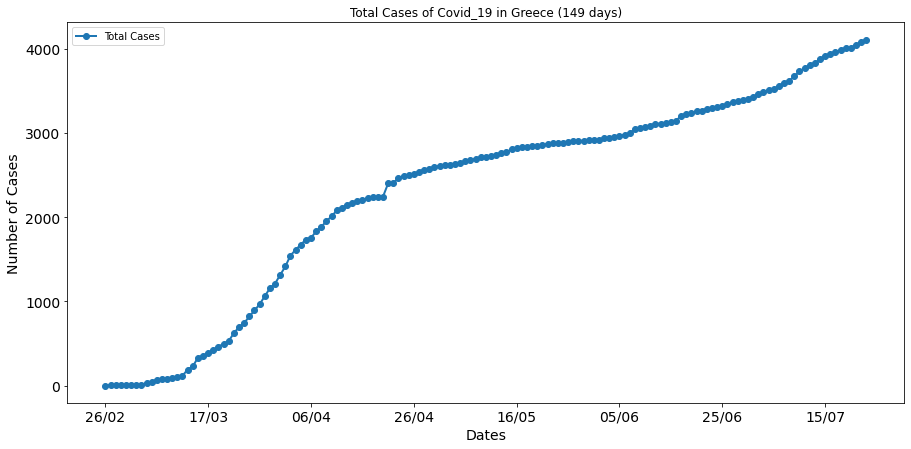

In [19]:
df[['Total Cases']].plot(figsize=(15,7), linewidth=2, fontsize=14, 
                         title='Total Cases of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)',  
                         marker='o')
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.legend()
plt.savefig(dir_name + "/TotalCases_" + today_date + ".png", bbox_inches='tight')

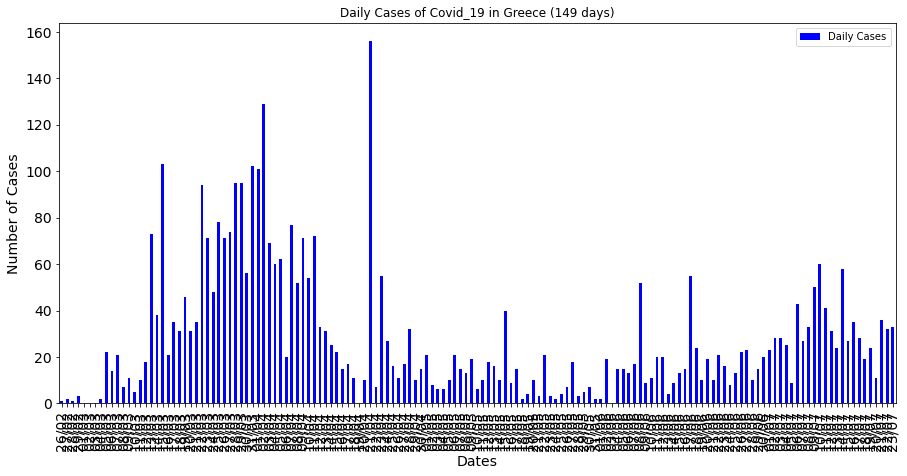

In [20]:
df['Daily Cases'].plot(kind='bar', figsize=(15,7), color="blue", fontsize=14)
plt.title('Daily Cases of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)')
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.legend()
plt.savefig(dir_name + "/DailyCasesBars_" + today_date + ".png", bbox_inches='tight')

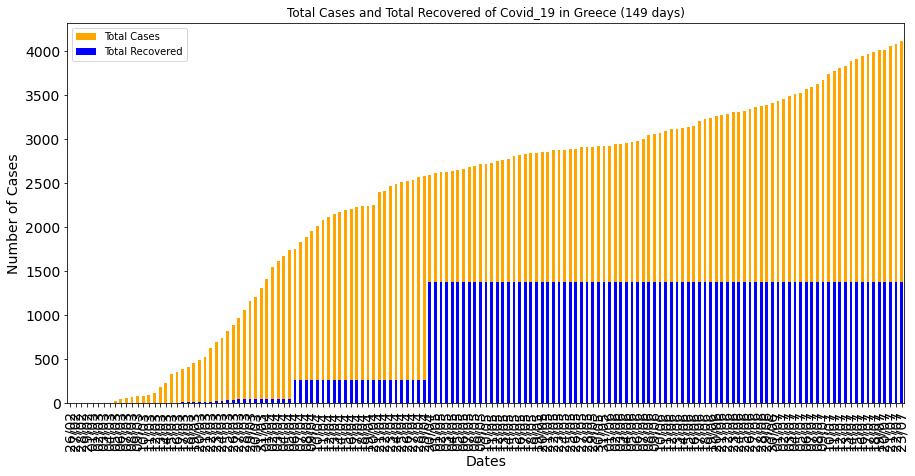

In [21]:
df['Total Cases'].plot(kind='bar', figsize=(15,7), color='orange', fontsize=14)
df['Total Recovered'].plot(kind='bar', figsize=(15,7), color='blue', fontsize=14)
plt.title('Total Cases and Total Recovered of Covid_19 in Greece ('+str(len(df['Total Cases']))+' days)')
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.legend()
plt.savefig(dir_name + '/TotalCases_Recovered_' + today_date + '.png', bbox_inches='tight')

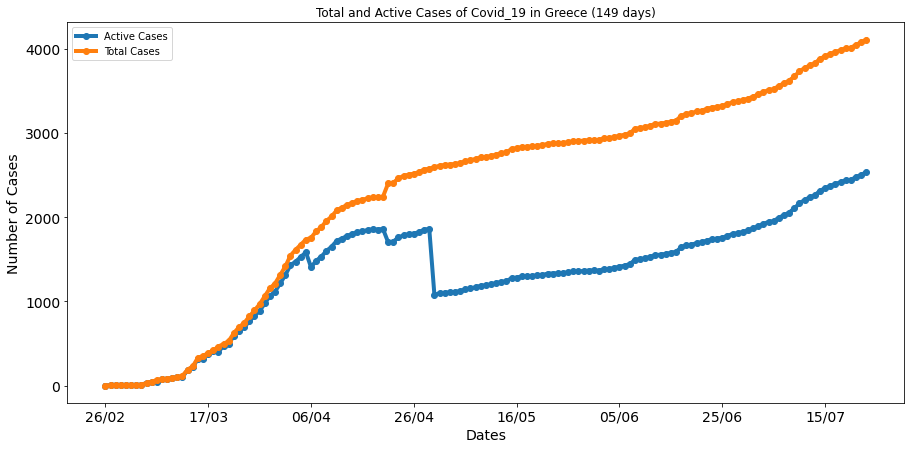

In [22]:
df[['Active Cases', 'Total Cases']].plot(figsize=(15,7), linewidth=4, 
                                        fontsize=14, marker='o', title='Total and Active Cases of Covid_19 in Greece (' +str(len(df['Total Cases']))+' days)')
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.legend()
plt.savefig(dir_name + "/Total_ActiveCases_" + today_date + ".png", bbox_inches='tight')

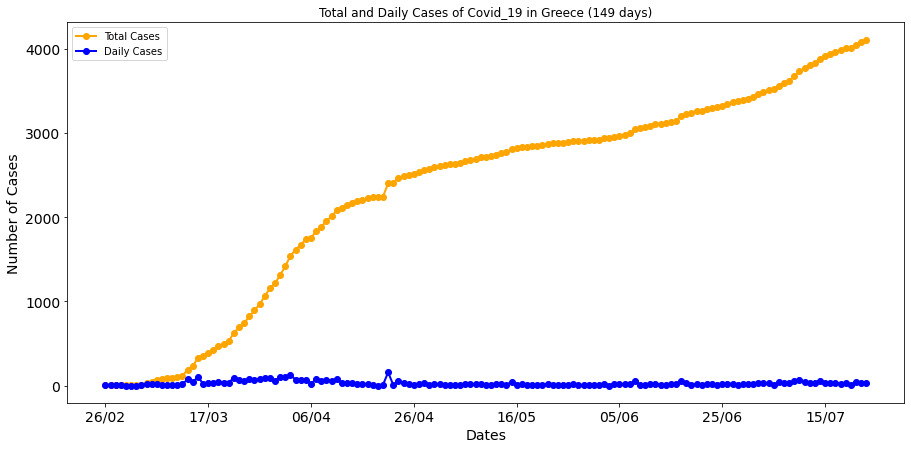

In [23]:
df[['Total Cases','Daily Cases']].plot(figsize=(15,7), linewidth=2, fontsize=14, color=['orange', 'blue'],
                                        title='Total and Daily Cases of Covid_19 in Greece (' +str(len(df['Total Cases']))+' days)', marker='o')
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Number of Cases', fontsize=14)
plt.legend()
plt.savefig(dir_name + "/TotalDaily_" + today_date + ".png", bbox_inches='tight')